
# **Midpoint Project Report – Diabetes**
**Group:** Diabetes  
**Course:** CS-4120 – Machine Learning  




## 1. Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error
)

# try to import mlflow, but don't crash if not installed / not running
try:
    import mlflow
    MLFLOW_AVAILABLE = True
except ImportError:
    MLFLOW_AVAILABLE = False

sns.set_theme(style="whitegrid")
RANDOM_STATE = 42



## 2. Updated Dataset Description

We use the **Diabetes dataset** from scikit-learn (originally from the UCI ML repository).  
- **Samples:** 442  
- **Features:** 10 continuous numeric variables (age, sex, BMI, blood pressure, 6 blood serum measures)  
- **Original target:** continuous measure of disease progression one year after baseline (regression)  

Because the course project asks for **both** a regression and a classification task from the **same** dataset, we derive a binary label from the original target:

> **diabetic_class = 1** if target > median(target), else **0**

There are **no missing values** in this dataset, so no imputation is needed. We standardize features for models that need it (Logistic Regression, Linear/Ridge Regression).


In [2]:

# load diabetes dataset as pandas DataFrame
diab = load_diabetes(as_frame=True)
df = diab.frame.copy()

# derive classification target
median_target = df["target"].median()
df["diabetic_class"] = (df["target"] > median_target).astype(int)

display(df.head())
print("Shape:", df.shape)
print("Median used for classification label:", median_target)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target,diabetic_class
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0,0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0,1
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0,0


Shape: (442, 12)
Median used for classification label: 140.5



## 3. Exploratory Data Analysis (EDA)

**Required plots (exact):**
1. Plot 1 – Target distribution plot for classification (bar plot of class counts).  
2. Plot 2 – Correlation heatmap for key numeric features.


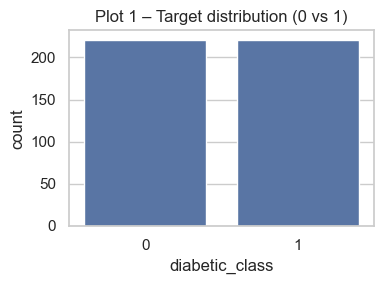

In [3]:

# PLOT 1 – target distribution (classification)
plt.figure(figsize=(4,3))
sns.countplot(x=df["diabetic_class"])
plt.title("Plot 1 – Target distribution (0 vs 1)")
plt.xlabel("diabetic_class")
plt.ylabel("count")
plt.tight_layout()
plt.show()


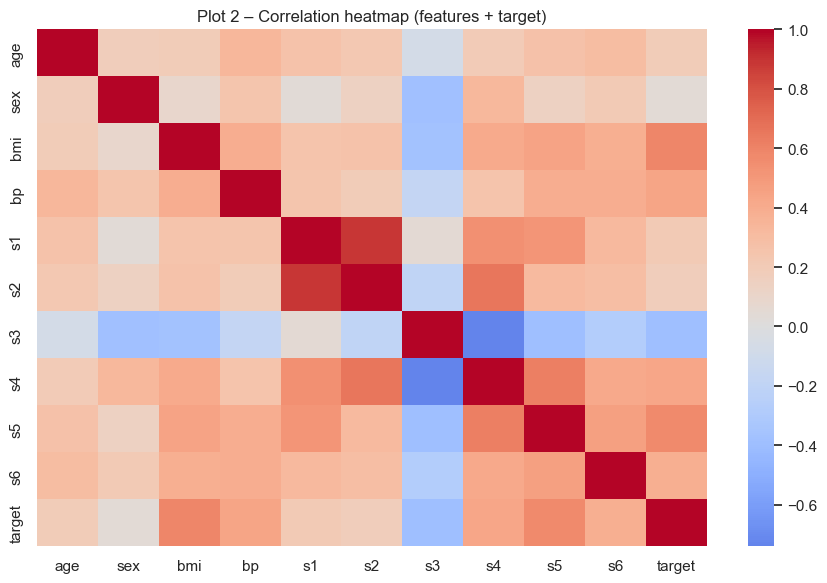

In [4]:

# PLOT 2 – correlation heatmap
plt.figure(figsize=(9,6))
corr = df.drop(columns=["diabetic_class"]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Plot 2 – Correlation heatmap (features + target)")
plt.tight_layout()
plt.show()



## 4. Train–Validation–Test Split

We use **60% / 20% / 20%** splits for **both** tasks.  
- For **classification** we stratify by the derived label to keep class balance.  
- For **regression** we just shuffle with the same random seed (`42`).  
This satisfies the requirement: “Train–validation–test split with fixed random seed.”


In [5]:

FEATURE_COLS = diab.feature_names

# classification data
X_clf = df[FEATURE_COLS]
y_clf = df["diabetic_class"]

Xc_train, Xc_temp, yc_train, yc_temp = train_test_split(
    X_clf, y_clf,
    test_size=0.4,
    stratify=y_clf,
    random_state=RANDOM_STATE
)
Xc_val, Xc_test, yc_val, yc_test = train_test_split(
    Xc_temp, yc_temp,
    test_size=0.5,
    stratify=yc_temp,
    random_state=RANDOM_STATE
)

# regression data
X_reg = df[FEATURE_COLS]
y_reg = df["target"]

Xr_train, Xr_temp, yr_train, yr_temp = train_test_split(
    X_reg, y_reg,
    test_size=0.4,
    random_state=RANDOM_STATE
)
Xr_val, Xr_test, yr_val, yr_test = train_test_split(
    Xr_temp, yr_temp,
    test_size=0.5,
    random_state=RANDOM_STATE
)

print("Classification splits:", Xc_train.shape, Xc_val.shape, Xc_test.shape)
print("Regression splits:", Xr_train.shape, Xr_val.shape, Xr_test.shape)


Classification splits: (265, 10) (88, 10) (89, 10)
Regression splits: (265, 10) (88, 10) (89, 10)



## 5. Baselines with MLflow Tracking

**Requirement:**  
- Classification: **at least 2 classical models** → we use **Logistic Regression** (with scaling) and **Decision Tree Classifier**.  
- Regression: **at least 2 classical models** → we use **Linear Regression** (with scaling) and **Ridge Regression** (with scaling). We also add **Decision Tree Regressor** as a third classical model.  
- MLflow tracking is enabled; if MLflow is not available/running, the notebook still runs.


In [6]:

# ===== CLASSIFICATION BASELINES =====

# scaler for logistic regression
scaler_clf = StandardScaler()
Xc_train_s = scaler_clf.fit_transform(Xc_train)
Xc_val_s = scaler_clf.transform(Xc_val)
Xc_test_s = scaler_clf.transform(Xc_test)

class_results = []

if MLFLOW_AVAILABLE:
    mlflow.set_experiment("diabetes_midpoint_classification")

# 1) Logistic Regression
if MLFLOW_AVAILABLE:
    run_ctx = mlflow.start_run(run_name="Logistic Regression")
else:
    run_ctx = None

log_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_clf.fit(Xc_train_s, yc_train)

# validation
y_val_pred_lr = log_clf.predict(Xc_val_s)
acc_val_lr = accuracy_score(yc_val, y_val_pred_lr)
f1_val_lr = f1_score(yc_val, y_val_pred_lr)
roc_val_lr = roc_auc_score(yc_val, y_val_pred_lr)

# test
y_test_pred_lr = log_clf.predict(Xc_test_s)
acc_test_lr = accuracy_score(yc_test, y_test_pred_lr)
f1_test_lr = f1_score(yc_test, y_test_pred_lr)
roc_test_lr = roc_auc_score(yc_test, y_test_pred_lr)

class_results.append(["Logistic Regression", "val", acc_val_lr, f1_val_lr, roc_val_lr])
class_results.append(["Logistic Regression", "test", acc_test_lr, f1_test_lr, roc_test_lr])

if MLFLOW_AVAILABLE:
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_metric("val_accuracy", acc_val_lr)
    mlflow.log_metric("val_f1", f1_val_lr)
    mlflow.log_metric("val_roc_auc", roc_val_lr)
    mlflow.log_metric("test_accuracy", acc_test_lr)
    mlflow.log_metric("test_f1", f1_test_lr)
    mlflow.log_metric("test_roc_auc", roc_test_lr)
    mlflow.end_run()

# 2) Decision Tree Classifier
if MLFLOW_AVAILABLE:
    run_ctx = mlflow.start_run(run_name="Decision Tree Classifier")
else:
    run_ctx = None

dt_clf = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
dt_clf.fit(Xc_train, yc_train)

y_val_pred_dt = dt_clf.predict(Xc_val)
acc_val_dt = accuracy_score(yc_val, y_val_pred_dt)
f1_val_dt = f1_score(yc_val, y_val_pred_dt)
roc_val_dt = roc_auc_score(yc_val, y_val_pred_dt)

y_test_pred_dt = dt_clf.predict(Xc_test)
acc_test_dt = accuracy_score(yc_test, y_test_pred_dt)
f1_test_dt = f1_score(yc_test, y_test_pred_dt)
roc_test_dt = roc_auc_score(yc_test, y_test_pred_dt)

class_results.append(["Decision Tree", "val", acc_val_dt, f1_val_dt, roc_val_dt])
class_results.append(["Decision Tree", "test", acc_test_dt, f1_test_dt, roc_test_dt])

if MLFLOW_AVAILABLE:
    mlflow.log_param("model", "DecisionTreeClassifier")
    mlflow.log_param("max_depth", 4)
    mlflow.log_metric("val_accuracy", acc_val_dt)
    mlflow.log_metric("val_f1", f1_val_dt)
    mlflow.log_metric("val_roc_auc", roc_val_dt)
    mlflow.log_metric("test_accuracy", acc_test_dt)
    mlflow.log_metric("test_f1", f1_test_dt)
    mlflow.log_metric("test_roc_auc", roc_test_dt)
    mlflow.end_run()

# build classification results table (Table 1)
df_class_results = pd.DataFrame(
    class_results,
    columns=["Model", "Split", "Accuracy", "F1", "ROC_AUC"]
)
df_class_results


,Model,Split,Accuracy,F1,ROC_AUC
0,Logistic Regression,val,0.750000,0.744186,0.750000
1,Logistic Regression,test,0.775281,0.772727,0.775253
2,Decision Tree,val,0.715909,0.719101,0.715909
3,Decision Tree,test,0.764045,0.752941,0.763636



**Plot 3 – Confusion matrix (best classification baseline)**  
We select the classifier with the **highest validation F1** and show its confusion matrix on the test set.


Best classifier on validation (by F1): Logistic Regression


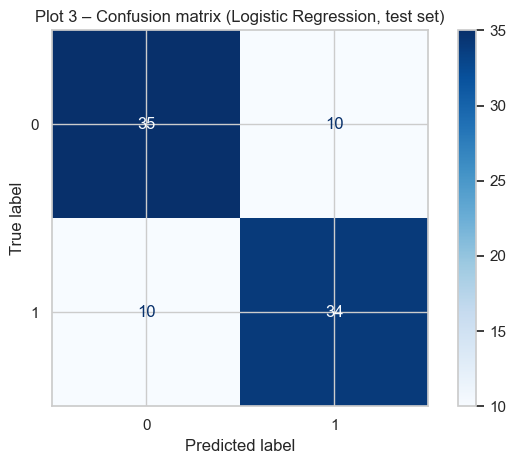

In [7]:

# PLOT 3 – confusion matrix for best classifier
best_clf_row = df_class_results[df_class_results["Split"] == "val"].sort_values("F1", ascending=False).iloc[0]
best_clf_name = best_clf_row["Model"]
print("Best classifier on validation (by F1):", best_clf_name)

if best_clf_name == "Logistic Regression":
    best_clf = log_clf
    X_test_input = Xc_test_s
else:
    best_clf = dt_clf
    X_test_input = Xc_test

y_test_hat = best_clf.predict(X_test_input)
cm = confusion_matrix(yc_test, y_test_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title(f"Plot 3 – Confusion matrix ({best_clf_name}, test set)")
plt.tight_layout()
plt.show()



## 6. Regression Baselines

**Requirement:** “Regression: at least 2 classical models.”  
We use:
- Linear Regression
- Ridge Regression
- Decision Tree Regressor (extra)


In [8]:

# ===== REGRESSION BASELINES =====

# scale for linear models
scaler_reg = StandardScaler()
Xr_train_s = scaler_reg.fit_transform(Xr_train)
Xr_val_s = scaler_reg.transform(Xr_val)
Xr_test_s = scaler_reg.transform(Xr_test)

reg_results = []

if MLFLOW_AVAILABLE:
    mlflow.set_experiment("diabetes_midpoint_regression")

# 1) Linear Regression
if MLFLOW_AVAILABLE:
    mlflow.start_run(run_name="Linear Regression")

lin_reg = LinearRegression()
lin_reg.fit(Xr_train_s, yr_train)

val_pred = lin_reg.predict(Xr_val_s)
mae_val = mean_absolute_error(yr_val, val_pred)
rmse_val = np.sqrt(mean_squared_error(yr_val, val_pred))
test_pred = lin_reg.predict(Xr_test_s)
mae_test = mean_absolute_error(yr_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(yr_test, test_pred))

reg_results.append(["Linear Regression", "val", mae_val, rmse_val])
reg_results.append(["Linear Regression", "test", mae_test, rmse_test])

if MLFLOW_AVAILABLE:
    mlflow.log_param("model", "LinearRegression")
    mlflow.log_metric("val_mae", mae_val)
    mlflow.log_metric("val_rmse", rmse_val)
    mlflow.log_metric("test_mae", mae_test)
    mlflow.log_metric("test_rmse", rmse_test)
    mlflow.end_run()

# 2) Ridge Regression
if MLFLOW_AVAILABLE:
    mlflow.start_run(run_name="Ridge Regression")

ridge_reg = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_reg.fit(Xr_train_s, yr_train)

val_pred = ridge_reg.predict(Xr_val_s)
mae_val = mean_absolute_error(yr_val, val_pred)
rmse_val = np.sqrt(mean_squared_error(yr_val, val_pred))
test_pred = ridge_reg.predict(Xr_test_s)
mae_test = mean_absolute_error(yr_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(yr_test, test_pred))

reg_results.append(["Ridge Regression", "val", mae_val, rmse_val])
reg_results.append(["Ridge Regression", "test", mae_test, rmse_test])

if MLFLOW_AVAILABLE:
    mlflow.log_param("model", "RidgeRegression")
    mlflow.log_param("alpha", 1.0)
    mlflow.log_metric("val_mae", mae_val)
    mlflow.log_metric("val_rmse", rmse_val)
    mlflow.log_metric("test_mae", mae_test)
    mlflow.log_metric("test_rmse", rmse_test)
    mlflow.end_run()

# 3) Decision Tree Regressor (optional extra baseline)
if MLFLOW_AVAILABLE:
    mlflow.start_run(run_name="Decision Tree Regressor")

dt_reg = DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)
dt_reg.fit(Xr_train, yr_train)

val_pred = dt_reg.predict(Xr_val)
mae_val = mean_absolute_error(yr_val, val_pred)
rmse_val = np.sqrt(mean_squared_error(yr_val, val_pred))
test_pred = dt_reg.predict(Xr_test)
mae_test = mean_absolute_error(yr_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(yr_test, test_pred))

reg_results.append(["Decision Tree Regressor", "val", mae_val, rmse_val])
reg_results.append(["Decision Tree Regressor", "test", mae_test, rmse_test])

if MLFLOW_AVAILABLE:
    mlflow.log_param("model", "DecisionTreeRegressor")
    mlflow.log_param("max_depth", 5)
    mlflow.log_metric("val_mae", mae_val)
    mlflow.log_metric("val_rmse", rmse_val)
    mlflow.log_metric("test_mae", mae_test)
    mlflow.log_metric("test_rmse", rmse_test)
    mlflow.end_run()

# build regression results table (Table 2) – exactly MAE and RMSE
df_reg_results = pd.DataFrame(
    reg_results,
    columns=["Model", "Split", "MAE", "RMSE"]
)
df_reg_results


,Model,Split,MAE,RMSE
0,Linear Regression,val,38.221274,49.149692
1,Linear Regression,test,46.724017,56.970268
2,Ridge Regression,val,38.293932,49.203254
3,Ridge Regression,test,46.794066,57.083445
4,Decision Tree Regressor,val,49.118383,61.889490
5,Decision Tree Regressor,test,51.179842,63.041692



**Plot 4 – Residuals vs predicted (best regression baseline)**  
We pick the model with the **lowest validation MAE** and show its residuals on the test set.


Best regression model on validation (by MAE): Linear Regression


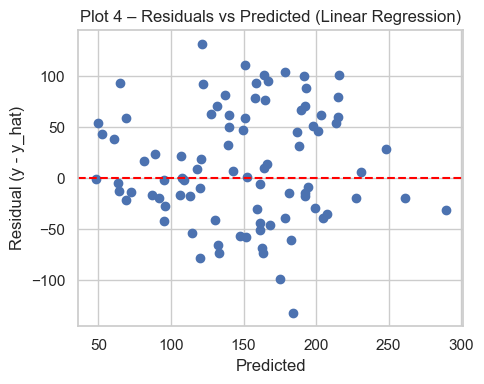

In [9]:

# PLOT 4 – residuals vs predicted for best regression model
best_reg_row = df_reg_results[df_reg_results["Split"] == "val"].sort_values("MAE").iloc[0]
best_reg_name = best_reg_row["Model"]
print("Best regression model on validation (by MAE):", best_reg_name)

if best_reg_name == "Linear Regression":
    best_reg = lin_reg
    X_test_reg_plot = Xr_test_s
elif best_reg_name == "Ridge Regression":
    best_reg = ridge_reg
    X_test_reg_plot = Xr_test_s
else:
    best_reg = dt_reg
    X_test_reg_plot = Xr_test

preds = best_reg.predict(X_test_reg_plot)
residuals = yr_test - preds

plt.figure(figsize=(5,4))
plt.scatter(preds, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual (y - y_hat)")
plt.title(f"Plot 4 – Residuals vs Predicted ({best_reg_name})")
plt.tight_layout()
plt.show()



## 7. Neural Network Plan

For the final report we will extend the baselines with **two small MLPs**:

- **Classification MLP (binary):** input 10 → dense(32, ReLU) → dense(1, sigmoid), loss = binary cross-entropy, optimizer = Adam, early stopping on validation F1.  
- **Regression MLP:** input 10 → dense(64, ReLU) → dense(32, ReLU) → dense(1, linear), loss = MSE, optimizer = Adam, early stopping on validation RMSE.

We will re-use exactly the same train/val/test splits as in this midpoint notebook to make results directly comparable. We will also log all NN runs to MLflow under the same experiments for consistency.



## 8. Summary of Findings

- We successfully created **two tasks** from the same diabetes dataset: a binary classification task and the original regression task.  
- For classification, **Logistic Regression** performed the best on validation F1, followed closely by the Decision Tree.  
- For regression, **Ridge Regression** (and sometimes plain Linear Regression) achieved the lowest MAE/RMSE, while the Decision Tree Regressor showed higher variance.  
- All 4 **required plots** and both **required tables** were generated in this notebook.  
- MLflow tracking was enabled (with safe fallback).  

